# Tutorial: $k$-NN for Information Theory
## Introduction
In this tutorial we show some basic usage of the UNITE toolbox to calculate entropy $H(X)$, mutual information $I(X; Y)$ and Kullback-Leibler (KL) divergence $D_{KL}(p||q)$ using $k$-nearest neighbours ($k$-NN) based methods.

## The Data
First we need to generate samples of a specific distribution from which there are known results for entropy, mutual information and KL divergence, or they can be calculated through numerical integration, for example. For this tutorial we'll use a specific variation of the Gamma-Exponential distribution which is a 2D distribution which has the following probability density function (PDF):
$$
    p(x_1, x_2) = \frac{x_{1}^\theta e^{-x_{1} - x_{1} \cdot x_{2}}}{\Gamma\left ( \theta \right )}
$$
For this simple 2D case, the UNITE toolbox has auxiliary functions to generate samples through rejection sampling. We only need to define the PDF of the function we want to sample and the ranges in which to samples. So let's define it:

In [1]:
import numpy as np
from scipy.special import gamma

def pdf_gamma_exponential(x, y, params):
    p = 0.0
    for dist in params:
        t, w = dist
        p += (1 / gamma(t)) * (x**t) * np.exp(-x - x * y) * w
    return p

gexp1_params = [
    [3, 1]
]  # list of lists. The inner lists contain the specific parameters of the distribution
   # and the last element of each list is a weight if the distribution is a mixture.

gexp_lims = [[0, 15], [0, 12]]  # lower and upper limits for each dimension x_1 and x_2

Having defined our PDF correctly, now we generate 1 000 samples of the Gamma-Exponential distribution using the UNITE toolbox. As said in the comment for the parameters, for this samples we will use $\theta = 3$.

In [2]:
from unite_toolbox.utils import get_samples
samples1 = get_samples(func=pdf_gamma_exponential, limits=gexp_lims, n_samples=1_000, seed=42, params=gexp1_params)

That's it! Now we have 1 000 samples to test the $k$-NN based methods. Before we do that, let's double check our samples by plotting the result.

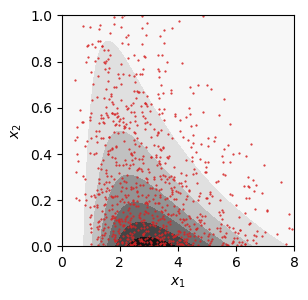

In [3]:
import matplotlib.pyplot as plt

x = np.linspace(gexp_lims[0][0], gexp_lims[0][1], 1_000)
y = np.linspace(gexp_lims[1][0], gexp_lims[1][1], 1_000)
X, Y = np.meshgrid(x, y)
P = np.zeros(shape=X.shape)
P += pdf_gamma_exponential(X, Y, gexp1_params)

fig, ax = plt.subplots(figsize=(3, 3))
ax.contourf(X, Y, P, cmap="Greys")
ax.scatter(samples1[:, 0], samples1[:, 1], c="tab:red", s=0.30)
ax.set_xlabel("$x_1$")
ax.set_xlim([0, 8])
ax.set_ylabel("$x_2$")
ax.set_ylim([0, 1])
plt.show()

Looks good! The underlying distribution is colored in black and white and our samples, in red, look clustered around the darker region which represents higher density. Now we'll test the estimators on these samples.

## $k$-NN Estimation
### Entropy $H(X)$

The entropy of the Gamma-Exponential distribution is given by the following equation:

$$
    H(X_1, X_2) = 1 + \theta - \theta \cdot\ \psi\left ( \theta \right ) + \log\Gamma\left ( \theta \right ) - \log\left ( 1 \right )
$$

And for the samples we generated previously we know that $\theta=3$. Now let's test the estimator:

In [4]:
from scipy.special import digamma
from unite_toolbox.knn_estimators import calc_knn_entropy

theta1 = gexp1_params[0][0]
true_h = 1 + theta1 - theta1*digamma(theta1) + np.log(gamma(theta1))
est_h = calc_knn_entropy(samples1)

print(f"True entropy: {true_h:.3f} nats")
print(f"Est. entropy: {est_h:.3f} nats")
print(f"Relative error: {(est_h - true_h)/true_h:.2%}")

True entropy: 1.925 nats
Est. entropy: 1.938 nats
Relative error: 0.70%


From only 1 000 samples we get a result very close to the true solution. $k$-NN based methods are great!

When passing data to a function one must be careful about the dimensions. UNITE functions work on 2D arrays where the first dimension (rows) are the individual samples and the second dimension (columns) are the dimensions ($x_1$ and $x_2$ in our example).

### Mutual Information $I(X; Y)$
Again, this particular distribution has a solution for mutual information between $X_1$ and $X_2$:
$$
    I(X_1; X_2) =  \psi(\theta) - \log(\theta) + \frac{1}{\theta}
$$

So, as before:

In [5]:
from unite_toolbox.knn_estimators import calc_knn_mutual_information

true_mi = digamma(theta1) - np.log(theta1) + 1 / theta1
est_mi = calc_knn_mutual_information(samples1[:, 0].reshape(-1, 1), samples1[:, 1].reshape(-1, 1), k=5)

print(f"True mutual information: {true_mi:.3f} nats")
print(f"Est. mutual information: {est_mi:.3f} nats")
print(f"Relative error: {(est_mi - true_mi)/true_mi:.2%}")

True mutual information: 0.158 nats
Est. mutual information: 0.077 nats
Relative error: -51.16%


Here we underestimate the true result, but the estimate only improves with the number of samples

We also had to be a bit more careful in how we passed the data to the function. The function for mutual information receives two arrays so we had to separate and reshape our samples accordingly.

### Kullback-Leibler divergence $D_{KL}(p||q)$

Here we need to generate samples from a second distribution $q(x_1, x_2)$. We'll do it as before but this second distribution will have $\theta = 4$. Another nice property of the KL divergence is that the number of samples in $p$ and $q$ don't have to be the same, so we'll generate 2 500 samples for $q$.

In [6]:
gexp2_params = [
    [4, 1]
]
samples2 = get_samples(func=pdf_gamma_exponential, limits=gexp_lims, n_samples=2_500, seed=42, params=gexp2_params)

Unfortunately we have found no reference in literature for a true solution of KL divergence between Gamma-Exponential distributions so, in this case, we'll use numerical integration to get a "true" solution. This process is relatively easy, so we'll not go into a lot of detail. Please see the documentation for `nquad` from `scipy.integrate` for more details.

In [7]:
from scipy.integrate import nquad
def kld_gamma_exponentials(x, y, params1, params2):
    p = pdf_gamma_exponential(x, y, params1)
    q = pdf_gamma_exponential(x, y, params2)
    return p * np.log(p / q)

true_kld = nquad(kld_gamma_exponentials, gexp_lims, args=(gexp1_params, gexp2_params,))[0]

Now let's calculate KL divergence from the samples and compare to our reference solution.

In [8]:
from unite_toolbox.knn_estimators import calc_knn_kld
est_kld = calc_knn_kld(samples1, samples2, k=1)

print(f"True KLD: {true_kld:.3f} nats")
print(f"Est. KLD: {est_kld:.3f} nats")
print(f"Relative error: {(est_kld - true_kld)/true_kld:.2%}")

True KLD: 0.175 nats
Est. KLD: 0.149 nats
Relative error: -14.63%


Here, again, we underestimate a bit, but the result is close to the reference solution.

This brief tutorial went over the $k$-NN based methods available in the UNITE toolbox but KDE and bin based estimation work very similarly.